In [1]:
# %load /home/sid/libs.txt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, make_scorer
from scipy.io.arff import loadarff
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

/home/sid/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def test_data_prep(*files):
    test_data = [pd.DataFrame(loadarff(file)[0]) for file in files]
    for i in range(len(test_data)):
        test_data[i]['class'].replace([b'0', b'1'], [0, 1], inplace = True)
    return test_data

In [3]:

test_df = test_data_prep('data/1year.arff', 'data/2year.arff', 'data/3year.arff', 'data/4year.arff', 'data/5year.arff')
# test_df

In [4]:
def test_train_splitter(data):
    X_train_2 = []
    X_test_2 = []
    y_train_2 = []
    y_test_2 = []
    X_val_2 = []
    y_val_2 = []
    for i in range(len(data)):
        X, y = data[i].iloc[:,:-1], data[i]['class']
        X.drop(['Attr37', 'Attr21'], axis=1, inplace=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)
        X_train.fillna(X_train.median(), inplace=True)
        X_test.fillna(X_test.median(), inplace=True)
#         Q3 = X_train.quantile(0.75)
#         Q1 = X_train.quantile(0.25)
#         IQR = Q3 - Q1
#         min = Q1 - 1.5 * IQR
#         max = Q3 + 1.5 * IQR
#         for col in X_train.columns:
#             X_train[col][X_train[col] < min[col]] = min[col]
#             X_train[col][X_train[col] > max[col]] = max[col]
        X_train_v, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 9)
        X_train_2.append(X_train_v)
        X_test_2.append(X_test)
        y_train_2.append(y_train)
        y_test_2.append(y_test)
        X_val_2.append(X_val)
        y_val_2.append(y_val)
    X_train_fin = pd.concat(X_train_2)
    X_test_fin = pd.concat(X_test_2)
    y_train_fin = pd.concat(y_train_2)
    y_test_fin = pd.concat(y_test_2)
    X_val_fin = pd.concat(X_val_2)
    y_val_fin = pd.concat(y_val_2)
    return X_train_fin, X_test_fin, X_val_fin, y_test_fin, y_train_fin, y_val_fin
        
X_train, X_test, X_val, y_test, y_train, y_val  = test_train_splitter(test_df)

/home/sid/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [5]:
# Defined a function for implementing hyper parameter tuning
def gridfunc(classifier, parameter, X_train, y_train):
        
    clf = classifier
    np.random.seed(9)
    parameters = parameter
    acc_scorer = make_scorer(roc_auc_score)
    
    # Run the grid search
    grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, n_jobs=-1)
    grid_obj = grid_obj.fit(X_train, y_train)
    
    return grid_obj

In [6]:
#plot mean scores for a particular grid object

def hp_cv_scores(grid_obj):
    grid_obj.cv_results_
    mean_test_scores = grid_obj.cv_results_['mean_test_score']
    mean_train_scores = grid_obj.cv_results_['mean_train_score']
    plt.figure(figsize=(10,6))
    
# #     param_values =[str(x) for x in list(grid_obj.param_grid.items())[0][1]]
#     x = np.arange(1, len(param_values)+1)
    
#     plt.plot(x,mean_train_scores, c='r', label='Train set')
#     plt.xticks(x,param_values)
#     plt.plot(x,mean_test_scores,c='g', label='Test set')
#     plt.xlabel(list(grid_obj.param_grid.items())[0][1])
#     plt.ylabel('mean scores')
#     plt.legend()
#     plt.show()

In [7]:
classifier = RandomForestClassifier(random_state=9, n_jobs=-1)

In [8]:
parameter = {'n_estimators': [10,50,100], 
              'max_features': ['log2', 'sqrt'], 
              'criterion': ['gini'],
              'max_depth': [5, 10], 
              'min_samples_split': [2],
              'min_samples_leaf': [1]
             }

In [9]:
grid = gridfunc(classifier, parameter, X_val, y_val)

In [10]:
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=9, verbose=0, warm_start=False)

In [11]:
clf = grid.best_estimator_
    
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=9, verbose=0, warm_start=False)

In [39]:
clf = RandomForestClassifier(n_estimators=10, random_state=9, criterion='gini')
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=9, verbose=0, warm_start=False)

In [40]:
y_pred = clf.predict(X_test)

Accuracy: 95.34%
F1_score:  0.242990654206
precision_score 0.691489361702
recall_score 0.147392290249
roc_auc_score 0.571936863397
cm matrix [[8213   29]
 [ 376   65]]


(441, 94)

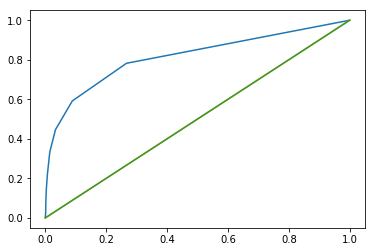

In [41]:
print "Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred) * 100)
print "F1_score: ", f1_score(y_test, y_pred)
print "precision_score", precision_score(y_test, y_pred)
print "recall_score", recall_score(y_test, y_pred)
print "roc_auc_score", roc_auc_score(y_test, y_pred)
print "cm matrix", confusion_matrix(y_test, y_pred)
scores = [n for m, n in clf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, scores)
plt.plot(fpr, tpr)
plt.plot([(0,0), (1,1)])
len(y_test[y_test == 1]), len(y_pred[y_pred == 1])

[0]	validation_0-logloss:0.611351
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.544157
[2]	validation_0-logloss:0.488667
[3]	validation_0-logloss:0.441411
[4]	validation_0-logloss:0.401292
[5]	validation_0-logloss:0.36669
[6]	validation_0-logloss:0.337204
[7]	validation_0-logloss:0.311297
[8]	validation_0-logloss:0.288041
[9]	validation_0-logloss:0.268163
[10]	validation_0-logloss:0.250884
[11]	validation_0-logloss:0.235411
[12]	validation_0-logloss:0.221482
[13]	validation_0-logloss:0.209677
[14]	validation_0-logloss:0.199382
[15]	validation_0-logloss:0.190064
[16]	validation_0-logloss:0.18138
[17]	validation_0-logloss:0.173878
[18]	validation_0-logloss:0.167425
[19]	validation_0-logloss:0.161679
[20]	validation_0-logloss:0.156124
[21]	validation_0-logloss:0.151399
[22]	validation_0-logloss:0.146998
[23]	validation_0-logloss:0.14326
[24]	validation_0-logloss:0.139641
[25]	validation_0-logloss:0.136303
[26]	validation_0-logloss:0.133562


(441, 111)

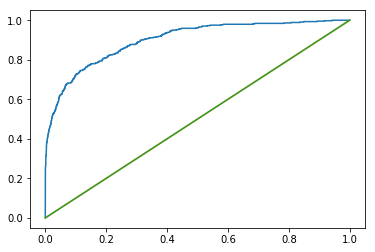

In [42]:
model = XGBClassifier()
eval_set = [(X_val, y_val)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
y_pred = model.predict(X_test)
print "Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred) * 100)
print "F1_score: ", f1_score(y_test, y_pred)
print "precision_score", precision_score(y_test, y_pred)
print "recall_score", recall_score(y_test, y_pred)
print "roc_auc_score", roc_auc_score(y_test, y_pred)
print "cm matrix", confusion_matrix(y_test, y_pred)
scores = [n for m, n in model.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, scores)
plt.plot(fpr, tpr)
plt.plot([(0,0), (1,1)])
len(y_test[y_test == 1]), len(y_pred[y_pred == 1])

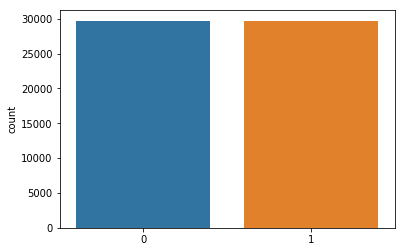

In [43]:
smote = SMOTE(random_state=9, kind = 'borderline2')
X_smote, y_smote = smote.fit_sample(X_train, y_train)
X_smote2 = pd.DataFrame(data=X_smote, columns=X_train.columns)[selected_features.index].copy()
sns.countplot(y_smote)
plt.show()

In [44]:
model = XGBClassifier()
eval_set = [(X_val, y_val)]
model.fit(X_smote, y_smote, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
y_pred = model.predict(X_test)
print "Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred) * 100)
print "F1_score: ", f1_score(y_test, y_pred)
print "precision_score", precision_score(y_test, y_pred)
print "recall_score", recall_score(y_test, y_pred)
print "roc_auc_score", roc_auc_score(y_test, y_pred)
print "cm matrix", confusion_matrix(y_test, y_pred)
scores = [n for m, n in model.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, scores)
plt.plot(fpr, tpr)
plt.plot([(0,0), (1,1)])
len(y_test[y_test == 1]), len(y_pred[y_pred == 1])

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61'] [u'Attr1', u'Attr2', u'Attr3', u'Attr4', u'Attr5', u'Attr6', u'Attr7', u'Attr8', u'Attr9', u'Attr10', u'Attr11', u'Attr12', u'Attr13', u'Attr14', u'Attr15', u'Attr16', u'Attr17', u'Attr18', u'Attr19', u'Attr20', u'Attr22', u'Attr23', u'Attr24', u'Attr25', u'Attr26', u'Attr27', u'Attr28', u'Attr29', u'Attr30', u'Attr31', u'Attr32', u'Attr33', u'Attr34', u'Attr35', u'Attr36', u'Attr38', u'Attr39', u'Attr40', u'Attr41', u'Attr42', u'Attr43', u'Attr44', u'Attr45', u'Attr46', u'Attr47', u'Attr48', u'Attr49', u'Attr50', u'Attr51', u'Attr52', u'Attr53', u'Attr54', u'Attr55', u'Attr56', u'Attr57', u'Attr58', u'Attr59', u'Attr60', u'Attr61', u'Attr62', u'Attr63', u'Attr64']
expected f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f41, f40, f43, f42, f45, f44, f47, f46, f49, f48, f18, f23, f22, f21, f20, f27, f26, f25, f24, f29, f28, f61, f60, f12, f13, f19, f56, f57, f54, f55, f52, f53, f50, f51, f58, f59, f30, f31, f32, f33, f34, f35, f36, f37, f38, f39, f10, f11, f16, f17, f14, f15 in input data
training data did not have the following fields: Attr20, Attr28, Attr54, Attr55, Attr56, Attr57, Attr50, Attr51, Attr52, Attr53, Attr58, Attr59, Attr10, Attr11, Attr12, Attr13, Attr14, Attr15, Attr30, Attr17, Attr18, Attr19, Attr38, Attr39, Attr6, Attr7, Attr4, Attr5, Attr2, Attr3, Attr1, Attr8, Attr9, Attr31, Attr36, Attr34, Attr43, Attr42, Attr41, Attr35, Attr47, Attr46, Attr45, Attr44, Attr32, Attr49, Attr48, Attr33, Attr25, Attr24, Attr27, Attr26, Attr16, Attr23, Attr22, Attr61, Attr60, Attr63, Attr62, Attr29, Attr64, Attr40